In [51]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


pd.options.mode.chained_assignment = None
tf.random.set_seed(42)
np.random.seed(42)

In [47]:
train_data = pd.read_csv('/content/train.csv', sep = ',')
test_data = pd.read_csv('/content/test.csv', sep = ',')

In [48]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v

In [59]:
from sklearn.preprocessing import StandardScaler
def preprocess_dataframe(dataframe, is_train = True):

  dataframe.Sex = pd.Categorical(dataframe.Sex).codes
  dataframe.Embarked = pd.Categorical(dataframe.Embarked).codes
  dataframe['HasCabin'] = dataframe['Cabin'].notna()
  dataframe['HasCabin'] = dataframe['HasCabin'].apply(lambda x: 1 if x is True else 0)
  dataframe.fillna(dataframe.mean(), inplace = True)

# Feature engineering
  dataframe['FamilySize'] = dataframe.SibSp + dataframe.Parch + 1
  dataframe['IsAlone'] = 1
  dataframe['IsAlone'].loc[dataframe['FamilySize'] > 1] = 0
  dataframe['NameLength'] = dataframe['Name'].str.len()
  dataframe['Title'] = dataframe['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]


  title_amounts = dataframe['Title'].value_counts() < 10
  dataframe['Title'] = dataframe['Title'].apply(lambda x: 'Misc' if title_amounts.loc[x] == True else x)


  dataframe.Title = pd.Categorical(dataframe.Title).codes
  dataframe = dataframe.drop(columns = ['Name', 'Ticket', 'Cabin'])

  full_dataframe = dataframe.copy()

  labels = None

  columns = ['PassengerId']

  if (is_train):
    columns.append('Survived')
    labels = np.array(dataframe.Survived)
  
  dataframe.drop(columns = columns, inplace = True)


  return dataframe, labels, full_dataframe

In [69]:
def show_corr_hotmap(dataframe):
  k = 12
  corrmat = dataframe.corr()
  cols = corrmat.nlargest(k, 'Survived')['Survived'].index
  cm = np.corrcoef(dataframe[cols].values.T)
  sns.set(font_scale=1.25)
  fig, ax = plt.subplots(figsize=(10, 10))
  hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, ax=ax)
  plt.show()

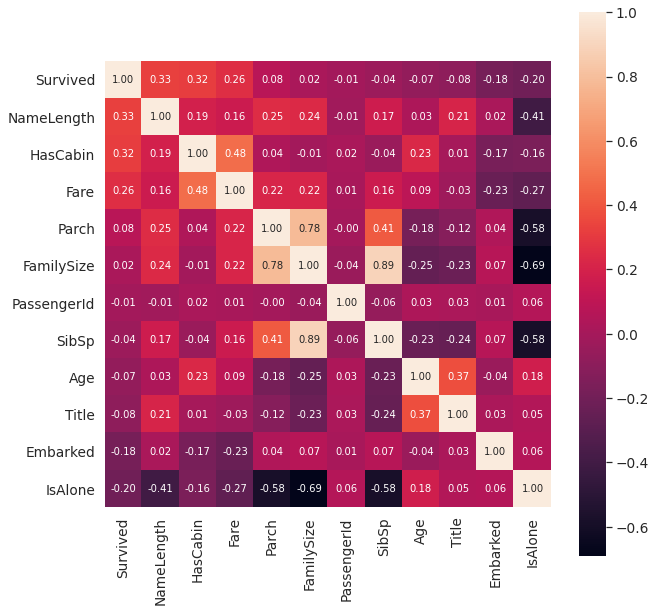

In [126]:
X_train, Y_train, full_dataframe = preprocess_dataframe(train_data, is_train = True)
X_test, Y_test, _ = preprocess_dataframe(test_data, is_train = False)

show_corr_hotmap(full_dataframe)

pandas_test = X_test

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()


scalar = StandardScaler()

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

X_whole = np.concatenate((X_train, X_test))

In [71]:
# implementation of 1cycle learning policy

class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [72]:
models = []

models.append(keras.Sequential([
                                keras.layers.BatchNormalization(),
                                keras.layers.Dense(1000, activation='elu', dtype='float32'),
                                keras.layers.BatchNormalization(),
                                keras.layers.Dense(100, activation='elu'),
                                keras.layers.BatchNormalization(),
                                keras.layers.Dense(20, activation='elu'),
                                keras.layers.BatchNormalization(),
                                keras.layers.Dense(2)
]))

models.append(keras.Sequential([
                                keras.layers.Dense(1024, activation='selu', dtype='float32'),
                                keras.layers.Dense(512, activation='selu'),
                                keras.layers.Dense(256, activation='selu'),
                                keras.layers.Dense(128, activation='selu'),
                                keras.layers.Dense(64, activation='selu'),
                                keras.layers.Dense(32, activation='selu'),
                                keras.layers.Dense(16, activation='selu'),
                                keras.layers.Dense(8, activation='selu'),
                                keras.layers.Dense(4, activation='selu'),
                                keras.layers.Dense(2)
]))

models.append(keras.Sequential([
                                keras.layers.Dropout(.1),
                                keras.layers.Dense(1024, activation='selu', dtype='float32'),
                                keras.layers.Dropout(.1),
                                keras.layers.Dense(512, activation='selu'),
                                keras.layers.Dropout(.1),
                                keras.layers.Dense(256, activation='selu'),
                                keras.layers.Dropout(.1),
                                keras.layers.Dense(128, activation='selu'),
                                keras.layers.Dropout(.1),
                                keras.layers.Dense(64, activation='selu'),
                                keras.layers.Dropout(.1),
                                keras.layers.Dense(32, activation='selu'),
                                keras.layers.Dropout(.1),
                                keras.layers.Dense(16, activation='selu'),
                                keras.layers.Dropout(.1),
                                keras.layers.Dense(8, activation='selu'),
                                keras.layers.Dropout(.1),
                                keras.layers.Dense(4, activation='selu'),
                                keras.layers.Dropout(.1),
                                keras.layers.Dense(2)
]))

In [ ]:
encoder = keras.Sequential([
                          keras.layers.Dense(300, activation='selu'),
                          keras.layers.Dense(50, activation='selu')
])

decoder = keras.Sequential([
                          keras.layers.Dense(300, activation='selu', input_shape=[50]),
                          keras.layers.Dense(X_whole[0].shape[0])
])

autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer='nadam', metrics=['accuracy'])
autoencoder_history = autoencoder.fit(X_whole, X_whole, epochs=1000,
                                      callbacks=[keras.callbacks.EarlyStopping('loss', patience=50, restore_best_weights=True)]
                                    )

In [152]:
input = keras.layers.Input(shape=X_train[0].shape)
encoder_ = encoder(input)
encoderr = encoder(input)
encoder_ = keras.layers.Dense(120, activation='selu')(encoder_)

#dense = keras.layers.Dense(1000, activation='selu')(input)
#dense = keras.layers.Dense(500, activation='selu')(dense)
#dense = keras.layers.Dense(100, activation='selu')(dense)

dense = keras.layers.Dropout(.1)(input)
dense = keras.layers.Dense(1024, activation='selu', dtype='float32')(dense)
dense = keras.layers.Dropout(.1)(dense)
dense = keras.layers.Dense(512, activation='selu')(dense)
dense = keras.layers.Dropout(.1)(dense)
dense = keras.layers.Dense(256, activation='selu')(dense)
dense = keras.layers.Dropout(.1)(dense)
dense = keras.layers.Dense(128, activation='selu')(dense)
dense = keras.layers.Dropout(.1)(dense)
dense = keras.layers.Dense(64, activation='selu')(dense)
dense = keras.layers.Dropout(.1)(dense)
dense = keras.layers.Dense(32, activation='selu')(dense)
dense = keras.layers.Dropout(.1)(dense)
dense = keras.layers.Dense(16, activation='selu')(dense)
dense = keras.layers.Dropout(.1)(dense)
dense = keras.layers.Dense(8, activation='selu')(dense)
dense = keras.layers.Dropout(.1)(dense)
dense = keras.layers.Dense(4, activation='selu')(dense)
dense = keras.layers.Dropout(.1)(dense)

concat = keras.layers.Concatenate()([input, encoderr, encoder_, dense])

output = keras.layers.Dense(2)(concat)

functional_model = keras.models.Model(inputs=[input], outputs=output)


models.append(functional_model)

In [159]:
tf.random.set_seed(42)
np.random.seed(42)

# compile, train then optimize the model

max_rate = .001

def model_preparation(model):
  custom_optimizer = keras.optimizers.Nadam()

  model.compile(optimizer=custom_optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
for model in models:
  model_preparation(model)

training_histories = []

n_epochs = 500
batch_size = 32

onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=max_rate, start_rate=max_rate/100)

history = models[3].fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs,
                                  validation_split=.3,
                                  callbacks=[
                                            onecycle, 
                                            keras.callbacks.EarlyStopping('val_loss', patience=50, restore_best_weights=True)
                                            #keras.callbacks.EarlyStopping('loss', patience=5, restore_best_weights=True)
                                            ], verbose=1)

training_histories.append(history)

Epoch 1/15
28/28 [==============================] - 1s 21ms/step - loss: 0.3555 - accuracy: 0.8474
Epoch 2/15
28/28 [==============================] - 1s 21ms/step - loss: 0.3581 - accuracy: 0.8541
Epoch 3/15
28/28 [==============================] - 1s 21ms/step - loss: 0.3628 - accuracy: 0.8541
Epoch 4/15
28/28 [==============================] - 1s 21ms/step - loss: 0.3594 - accuracy: 0.8485
Epoch 5/15
28/28 [==============================] - 1s 20ms/step - loss: 0.3577 - accuracy: 0.8485
Epoch 6/15
28/28 [==============================] - 1s 20ms/step - loss: 0.3611 - accuracy: 0.8474


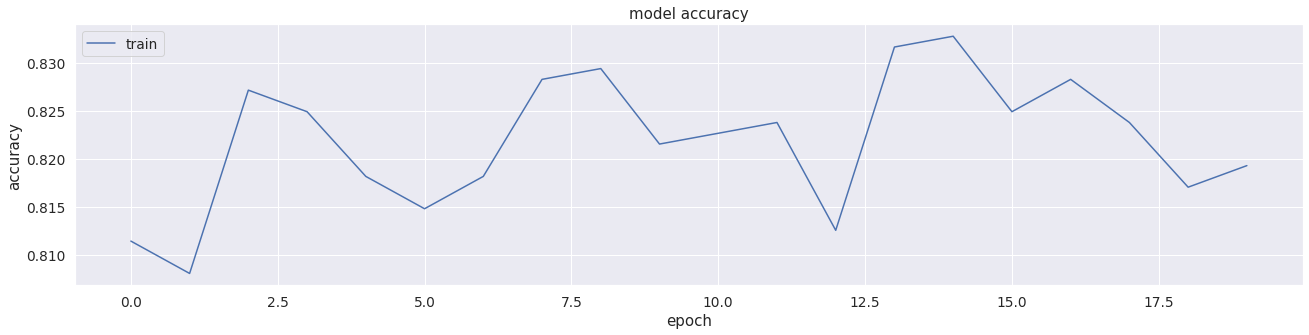

In [113]:
def plot_history_accuracy(training_history):

  plt.figure(figsize=[22., 4.8])
  plt.plot(training_history.history['accuracy'])
  if 'val_accuracy' in training_history.history:
    plt.plot(training_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

for history in training_histories:
  plot_history_accuracy(history)

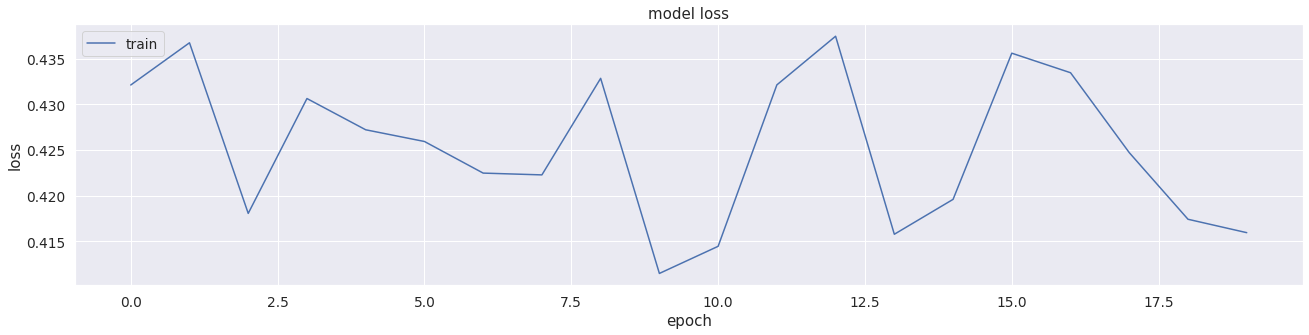

In [114]:
def plot_history_loss(training_history):

  plt.figure(figsize=[22., 4.8])
  plt.plot(training_history.history['loss'])
  if 'val_loss' in training_history.history:
    plt.plot(training_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

for history in training_histories:
  plot_history_loss(history)

In [165]:
def predict(model):
  prediction_model = tf.keras.Sequential([model,
                                          tf.keras.layers.Softmax()])

  return np.argmax(prediction_model.predict(X_test), axis = 1)

def predict_ensemble(model):
  prediction_model = tf.keras.Sequential([model,
                                        tf.keras.layers.Softmax()])
  return prediction_model.predict(X_test)[:, 1]


"""

# predict using a single model
preds = np.c_[
      predict(models[3])
]


"""

# predict using ensemble
preds = np.c_[
      predict_ensemble(models[0]),
      predict_ensemble(models[1]),
      predict_ensemble(models[2]),
      predict_ensemble(models[3]),
      ]

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [85]:
svm_prediction = np.array(clf.predict(X_test))

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
#C: 2, decision_function_shape='ovo', gamma=0.1, probability=True, random_state=0
sk_models = [
    RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=100, oob_score=True, random_state=0),
    AdaBoostClassifier(learning_rate=0.1, n_estimators=300, random_state=0),
    BaggingClassifier(base_estimator=SVC(), n_estimators=300, max_samples=0.25, random_state=0),
    ExtraTreesClassifier(criterion='entropy', max_depth=6, n_estimators=100, random_state=0),
    GradientBoostingClassifier(random_state=0)
]

sk_results = []

for model in sk_models:
  model.fit(X_train, Y_train)
  sk_results.append(model.predict(X_test))

sk_results = np.array(sk_results)

In [89]:
#Scikit-learn ensemble
predictions = np.c_[np.arange(892, 1310), np.mean(sk_results, axis=0).round()]


In [166]:
#Tensorflow ensemble
predictions = np.c_[np.arange(892, 1310), np.mean(preds, axis=1).round()]

In [161]:
predictions = np.c_[np.arange(892, 1310), preds]

In [167]:
np.savetxt('/content/predictions.csv', predictions, delimiter=",", header='PassengerId,Survived', fmt='%d', comments='')